In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics
import myfm
from myfm import RelationBlock
import pandas as pd
from scipy import sparse as sps
from mapper import DefaultMapper

# read movielens 100k data.
from movielens1M_data import MovieLens1MDataManager

In [2]:
data_manager = MovieLens1MDataManager()
df_train, df_test = data_manager.load_rating()

# For ordered probit. rating values are now [0, 1, 2, 3, 4].
df_train.rating -= 1
df_test.rating -= 1

user_to_internal = DefaultMapper(df_train.user_id.values)
movie_to_internal = DefaultMapper(df_train.movie_id)

In [3]:
# treat the days of events as categorical variable
date_be = OneHotEncoder(handle_unknown='ignore').fit(
    df_train.timestamp.dt.date.values.reshape(-1, 1)
)

def categorize_date(df):
    return date_be.transform(df.timestamp.dt.date.values[:, np.newaxis])

## Implement flavor of SVD++

We add "all users who have evaluated a movie in the train set" as the movie's feature.

In [4]:
# Implement side information and flavor of SVD++
# We add "all users who have evaluated a movie in the train set" or
# "all movies rated by a user" as a feture of user/movie.
use_date = True # use date info or not
use_iu = True # use implicit user feature
use_ii = True # use implicit item feature

movie_vs_watched = dict()
user_vs_watched = dict()
for row in df_train.itertuples():
    user_id = row.user_id
    movie_id = row.movie_id
    movie_vs_watched.setdefault(movie_id, list()).append(user_id)
    user_vs_watched.setdefault(user_id, list()).append(movie_id)

if use_date:
    X_date_train = categorize_date(df_train)
    X_date_test  = categorize_date(df_test)
else:
    X_date_train, X_date_test = (None, None)

In [5]:
# setup grouping
feature_group_sizes = []
if use_date:
    feature_group_sizes.append(
        len(date_be.categories_[0]), # date
    )

feature_group_sizes.append(len(user_to_internal)) # user ids

if use_iu:
    feature_group_sizes.append(len(movie_to_internal))

feature_group_sizes.append(len(movie_to_internal)) # movie ids
                           
if use_ii:
    feature_group_sizes.append(
        len(user_to_internal) # all users who watched the movies
    )

grouping = [ i for i, size in enumerate(feature_group_sizes) for _ in range(size)]

In [6]:
# given user/movie ids, add additional infos and return it as sparse
def augment_user_id(user_ids):
    X = sps.lil_matrix((len(user_ids), len(user_to_internal) + (len(movie_to_internal) if use_iu else 0) ))
    for index, user_id in enumerate(user_ids):
        X[index, user_to_internal[user_id]] = 1
        if not use_iu:
            continue
        watched_movies = user_vs_watched.get(user_id, [])
        normalizer = 1 / max(len(watched_movies), 1) ** 0.5
        for mid in watched_movies:
            X[index, movie_to_internal[mid] + len(user_to_internal)] = normalizer
    return X.tocsr()

def augment_movie_id(movie_ids):
    X = sps.lil_matrix((len(movie_ids), len(movie_to_internal)+ (len(user_to_internal) if use_ii else 0 )))
    for index, movie_id in enumerate(movie_ids):
        X[index, movie_to_internal[movie_id]] = 1
        if not use_ii:
            continue
        watched_users = movie_vs_watched.get(movie_id, [])
        normalizer = 1 / max(len(watched_users), 1) ** 0.5
        for uid in watched_users:
            X[index, user_to_internal[uid] + len(movie_to_internal)] = normalizer
    return X.tocsr()

## Use Relation Block Format to represent the data
See [\[Rendle 2013\]](http://www.vldb.org/pvldb/vol6/p337-rendle.pdf) how comlexity dcrease drastically in this case (and most cases with bipartite graph structure).

In [7]:
# Create RelationBlock.
train_blocks = []
test_blocks = []
for source, target in [(df_train, train_blocks), (df_test, test_blocks)]:
    unique_users, user_map = np.unique(source.user_id, return_inverse=True)
    target.append(
        RelationBlock(user_map, augment_user_id(unique_users))
    )
    unique_movies, movie_map = np.unique(source.movie_id, return_inverse=True)
    target.append(
        RelationBlock(movie_map, augment_movie_id(unique_movies))
    )

### Regression

In [8]:
fm = myfm.MyFMRegressor(rank=32)
fm.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    grouping=grouping,
    n_iter=512
);

alpha = 1.88 w0 = 2.38 : 100%|██████████| 512/512 [19:00<00:00,  2.21s/it]


### Ordered Probit Regression

In [9]:
fm_ordered = myfm.MyFMOrderedProbit(rank=32)
fm_ordered.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    grouping=grouping,
    n_iter=512
);

w0= -0.131149, cutpoint = ['-2.569', '-1.516', '-0.207', '1.307'] : 100%|██████████| 512/512 [23:49<00:00,  2.79s/it]


In [10]:
test_prediction_regressor = fm.predict(X_date_test, test_blocks)

In [11]:
test_prediction_oprobit = fm_ordered.predict_proba(X_date_test, test_blocks)

In [12]:
test_prediction_oprobit_mean = test_prediction_oprobit.dot(np.arange(5))

In [13]:
# RMSE for regressor
(
    (df_test.rating.values - test_prediction_regressor)**2
).mean() ** 0.5

0.8210203214993141

In [14]:
# RMSE for ordered probit regressor
(
    (df_test.rating.values - test_prediction_oprobit_mean)**2
).mean() ** 0.5

0.818186602327164

### How cutpoints vs ratings looks like

Cutpoints curve w.r.t to corresponding rating boundary exhibits a slight non-linearity.

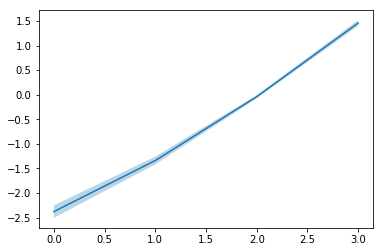

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
cutpoints = np.vstack([x.cutpoints[0] - x.w0 for x in fm_ordered.predictor_.samples])

cp_std = cutpoints.std(axis=0)
cp_mean = cutpoints.mean(axis=0)
plt.plot(cp_mean);
plt.fill_between(np.arange(4), cp_mean - 2 * cp_std, cp_mean + cp_std * 2, alpha=0.3)